In [1]:
"""
TODO to learn JAX:
1. Try to create a function, and get a grad function from it. Plot both functions.
2. Try to take consecutive gradients on a gradient function. Plot the series of gradient funcs.
3. Try to calculate the Jacobian of a function: R^n -> R. Check that the jacobian in this case is
the gradient (transpose).
4. Try to calculate the Jacobian of a function: R^n -> R using forward and reverse mode. Confirm
that reverse mode is much quicker in this case, because we are dealing with a very "wide" 
Jacboian.
5. Try to calculate the Hessian matrix. Try to use the correct forward and reverse jacobians.
6. Try to implement the Jacobian of a function: R^n -> R^m.
7. Implement Adam for gradient based optimisation.
8. Implement a second order gradient based optimiser.
9. Implement optimisation for a function with a higher dimensional codomain? (i.e. using a 
jacobian rather than a gradient...?)
10. Try to use the jacobian vector product (jvp). This gives an efficient way of calculating
the dot product between the jacobian and some vector?
""";

In [2]:
import jax.numpy as jnp
import jax
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# define a simple function
@jax.jit
def f(x):
    return jnp.sum(x**3)

x = np.linspace(-1, 1, 1000)[:,None]

### 1.Grad() and vmap()

In [4]:
# get gradient (function)
df = jax.grad(f)

In [5]:
# vectorize domain/data_dim
print(jax.vmap(f, in_axes=0)(x).shape)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


(1000,)


### 2. Grad of Grad

In [6]:
# jax uses arrays always, so if the output dimension is 1, we still need to use arrays.
# moreover, to use grad(), the output dimension must be 1 as an int or a float NOT array.
ddf = jax.grad(lambda x: jnp.sum(df(x)))

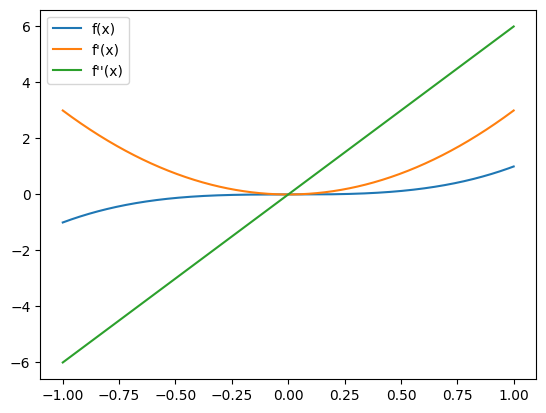

In [7]:
# show function and gradient (both vector evaluated with vmap)
plt.plot(x, jax.vmap(f, in_axes=0)(x),label="f(x)")
plt.plot(x, jax.vmap(df, in_axes=0)(x),label="f'(x)")
plt.plot(x, jax.vmap(ddf, in_axes=0)(x),label="f''(x)")
plt.legend()

### Jacobian R^n -> R. In other words, gradient using the jacfwd() method
Note, in this case we consider f: R^n -> R because we do not use vmap to batch over the first dim which makes it f: R -> R.

In [8]:
# check if jacfwd is the same as grad in this case
(jax.jacfwd(f)(x) == jax.grad(f)(x)).all()

Array(True, dtype=bool)

In [9]:
# PREFER jacrev is better for WIDE matrices, i.e. gradient-type
# Thus, normally WE PREFER JACREV as can be seen from below
%timeit -n 20 jax.jacfwd(f)(x)
%timeit -n 20 jax.jacrev(f)(x)

12.7 ms ± 318 µs per loop (mean ± std. dev. of 7 runs, 20 loops each)
3.33 ms ± 1.91 ms per loop (mean ± std. dev. of 7 runs, 20 loops each)


### 5. The Hessian

In [10]:
jax.jacfwd(jax.jacrev(f))(x).shape

(1000, 1, 1000, 1)

In [11]:
# Here it is easy to see why we prefer jacrev and THEN jacfwd, BIG SPEED DIFFERENCE
%timeit -n 20 jax.jacfwd(jax.jacrev(f))(np.linspace(-1,1,400))
%timeit -n 20 jax.jacrev(jax.jacfwd(f))(np.linspace(-1,1,400))

9.23 ms ± 4.91 ms per loop (mean ± std. dev. of 7 runs, 20 loops each)
101 ms ± 11.3 ms per loop (mean ± std. dev. of 7 runs, 20 loops each)


### 6. Jacobian R^n -> R^m

In [12]:
@jax.jit
def polar(X):
    r = jnp.sqrt(jnp.sum(X**2))
    phi = jnp.arctan2(*X[::-1])
    return jnp.stack([r,phi])

y = np.copy(x)

In [13]:
board = np.mgrid[-1:1:100j,-1:1:100j].T

In [14]:
X = np.concatenate((x,y),axis=-1)
X.shape

(1000, 2)

In [15]:
jax.vmap(polar,out_axes=0)(X).shape

(1000, 2)

In [16]:
# vmap only batches one dimension at a time.
# need consecutive calls of vmap to batch further dimensions
jax.vmap(jax.vmap(polar))(board).shape

(100, 100, 2)

In [17]:
J = jax.vmap(jax.vmap(jax.jacfwd(polar)))(board)
J.shape

(100, 100, 2, 2)

In [18]:
detJ = jnp.linalg.det(J)
detJ.shape

(100, 100)

Text(0.5, 1.0, 'det(J(x,y))')

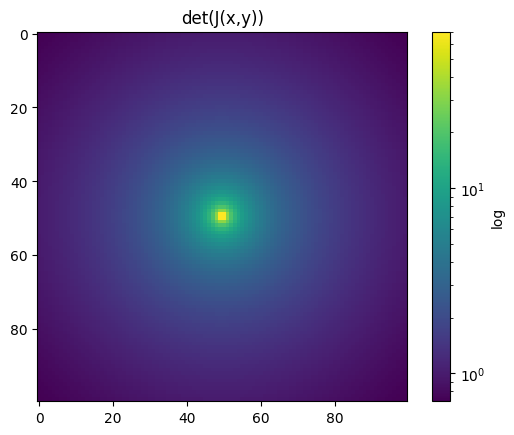

In [19]:
plt.imshow(detJ,norm='log')
plt.colorbar(label="log")
plt.title("det(J(x,y))")

### Gradient of multiple inputs (argnums)

In [20]:
def h(x,y):
    return sum(x*y)

In [21]:
jax.grad(h,argnums=(0,1))(*np.ones((2,1)))

(Array([1.], dtype=float32), Array([1.], dtype=float32))

### 7. Adam - using optax

In [22]:
import optax

In [23]:
@jax.jit
def f2(x):
    return sum(x**2)

In [24]:
# random starting point
x0 = np.random.normal(1,size=(1,))
xs = [x0]
print(xs)

[array([-0.23555325])]


In [25]:
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(x0)
opt_state

(ScaleByAdamState(count=Array(0, dtype=int32), mu=Array([0.], dtype=float32), nu=Array([0.], dtype=float32)),
 EmptyState())

In [26]:
df2 = jax.grad(f2)

In [27]:
import tqdm

for i in tqdm.trange(2000):
    grads = df2(xs[-1])
    updates, opt_state = optimizer.update(grads, opt_state)
    xs.append(xs[-1] + updates)

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:05<00:00, 396.15it/s]


[-2.35553250e-01 -2.34553263e-01 -2.33553380e-01 ... -3.55438044e-24
 -3.27802373e-24 -3.01813646e-24]


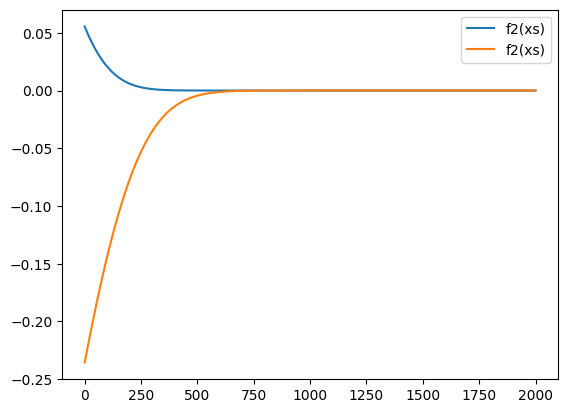

In [28]:
xs = np.array(xs)
plt.plot(jax.vmap(f2)(xs),label="f2(xs)")
plt.plot(xs[:,0],label="f2(xs)")
print(xs[:, 0])
plt.legend()
plt.show()